In [1]:
import numpy as np
import os
import pandas as pd
import h5py
from scipy.io import loadmat
import socket
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

hostname = socket.gethostname()
p = {}
if hostname == 'syndrome' or hostname == 'zod.psych.nyu.edu' or hostname == 'zod':
    p['datd'] = '/d/DATD/datd/MD_TMS_EEG'
else:
    p['datd'] = '/Users/mrugankdake/Documents/Clayspace/EEG_TMS/datd/MD_TMS_EEG'
p['data'] = p['datd'] + '/data'
p['analysis'] = p['datd'] + '/analysis'
p['EEGfiles'] = p['datd'] + '/EEGfiles'
p['meta'] = p['analysis'] + '/meta_analysis'
p['df_fname'] = os.path.join(p['meta'], 'calib_filtered.csv')
p['ALI_evoked'] = os.path.join(p['EEGfiles'], 'ALI_evoked.mat')
p['ALI_induced'] = os.path.join(p['EEGfiles'], 'ALI_induced.mat')
p['training_data'] = os.path.join(p['EEGfiles'], 'training_data.npy')
# Load up summary meta-data
summary_df = pd.read_csv(os.path.join(p['analysis'] + '/EEG_TMS_meta_Summary.csv'))
All_metadata = {row['Subject ID']: row for _, row in summary_df.iterrows()}

# Load up behavioral data
df_behav = pd.read_csv(p['df_fname'])
df_behav['trl_idx'] = df_behav['rnum'] * df_behav['tnum']

In [2]:
# Load up ALI evoked and induced
with h5py.File(p['ALI_evoked'], 'r') as f:
    X_evoked = np.array(f['mALI']).T
    y_evoked = np.array(f['trl_mat']).T
yevoked_df = pd.DataFrame(y_evoked, columns = ['subjID', 'day', 'istms', 't_type', 'trl_idx'], dtype='int')

with h5py.File(p['ALI_induced'], 'r') as f:
    X_induced = np.array(f['mALI']).T
    y_induced = np.array(f['trl_mat']).T
yinduced_df = pd.DataFrame(y_induced, columns = ['subjID', 'day', 'istms', 't_type', 'trl_idx'], dtype='int')

# Load up the time array
with h5py.File(os.path.join(p['EEGfiles'], 'sub01/day01/sub01_day01_TFR_evoked.mat')) as f:
    time_array = np.array(f['POW']['pin']['time'])

# Create data with just trials that were retained after both behavioral and EEG trial-rejection
master_df = pd.merge(df_behav.reset_index(), yevoked_df.drop(columns=['istms']).reset_index(), on=['subjID', 'day', 'trl_idx'], how='inner', indicator=True)
idx_behav = master_df['index_x'].tolist()
idx_ALI = master_df['index_y'].tolist()
master_df = master_df.drop(columns=['index_x', 'Unnamed: 0', 'index_y', '_merge'])
Xcommon_evoked = X_evoked[idx_ALI, :]
Xcommon_induced = X_induced[idx_ALI, :]

# Make a list of different trial-types
trial_types = ['pin', 'pout', 'ain', 'aout']
tms_cond = [0, 1]

In [3]:
# Compute ALI average per subject
sub_list = yevoked_df['subjID'].unique()
ALI_evoked = np.zeros((len(tms_cond), len(trial_types), len(sub_list), len(time_array)))
ALI_induced = np.zeros((len(tms_cond), len(trial_types), len(sub_list), len(time_array)))
for ii, cond in enumerate(tms_cond):
    for jj, t_type in enumerate(trial_types):
        idx = yevoked_df.loc[(yevoked_df['istms'] == cond) & (yevoked_df['t_type'] == jj+1)].index
        #print(len(idx))
        this_df = yevoked_df.iloc[idx].reset_index(drop=True)
        #print(this_df.head())
        this_X_evoked = X_evoked[idx, :]
        this_X_induced = X_induced[idx, :]
        for kk in range(len(sub_list)):
            this_idx = this_df.index[this_df['subjID'] == sub_list[kk]].tolist()
            ALI_evoked[ii, jj, kk, :] = np.nanmean(this_X_evoked[this_idx, :], 0)
            ALI_induced[ii, jj, kk, :] = np.nanmean(this_X_induced[this_idx, :], 0)

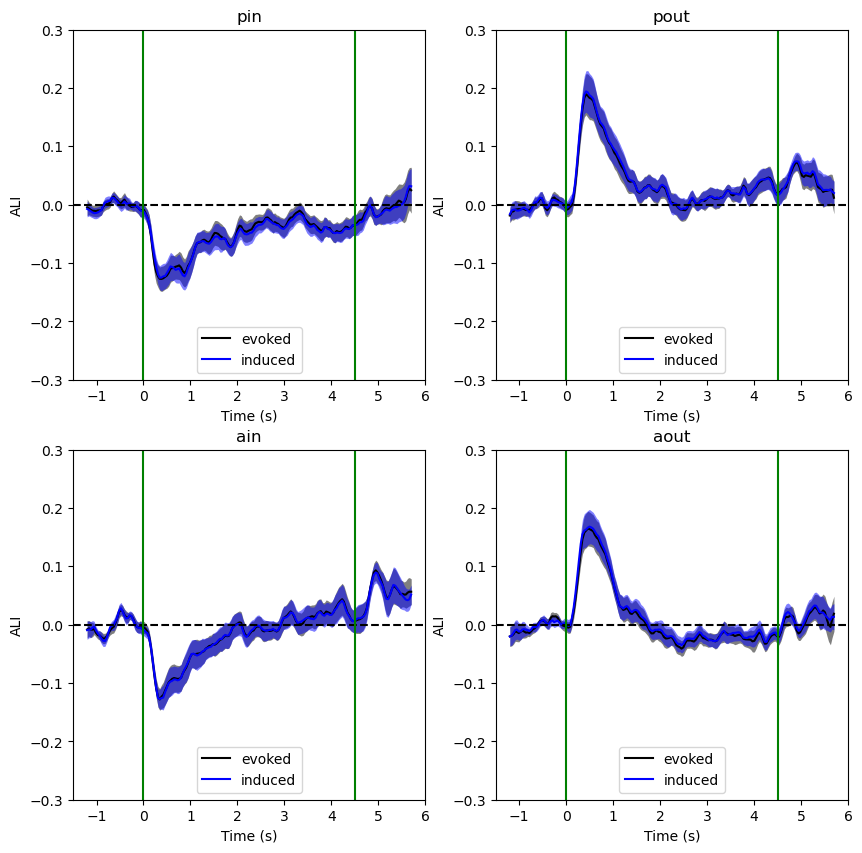

In [4]:
## ALIs for evoked vs induced for No TMS
lim_val = 0.3
f, axs = plt.subplots(2, 2, figsize=(10, 10))
for jj, ax in zip([0,1,2,3], axs.ravel()):
    y1 = np.nanmean(ALI_evoked[0, jj, :, :], 0)
    y2 = np.nanmean(ALI_induced[0, jj, :, :], 0)
    y1_err = np.nanstd(ALI_evoked[0, jj, :, :], 0)/np.sqrt(len(sub_list))
    y2_err = np.nanstd(ALI_induced[0, jj, :, :], 0)/np.sqrt(len(sub_list))
    ax.plot(time_array, y1, 'k-', label='evoked')
    ax.plot(time_array, y2, 'b-', label='induced')
    ax.fill_between(time_array[:,0], y1-y1_err, y1+y1_err, alpha=0.5, linewidth=0, color='k')
    ax.fill_between(time_array[:,0], y2-y2_err, y2+y2_err, alpha=0.5, linewidth=0, color='b')
    ax.plot(time_array, np.zeros(len(time_array)), 'k--')
    ax.plot([0, 0], [-lim_val, lim_val], 'g-')
    ax.plot([4.5, 4.5], [-lim_val, lim_val], 'g-')
    ax.legend()
    ax.set_xlim(time_array[0], time_array[-1])
    ax.set_ylim(-lim_val, lim_val)
    ax.set_ylabel('ALI')
    ax.set_xlabel('Time (s)')
    ax.set_title(trial_types[jj])

In [ ]:
## ALIs for evoked for No TMS vs TMS
lim_val = 0.3
f, axs = plt.subplots(2, 2, figsize=(10, 10))
for jj, ax in zip([0,1,2,3], axs.ravel()):
    y1 = np.nanmean(ALI_evoked[0, jj, :, :], 0)
    y2 = np.nanmean(ALI_evoked[1, jj, :, :], 0)
    y1_err = np.nanstd(ALI_evoked[0, jj, :, :], 0)/np.sqrt(len(sub_list))
    y2_err = np.nanstd(ALI_evoked[1, jj, :, :], 0)/np.sqrt(len(sub_list))
    ax.plot(time_array, y1, 'b-', label='no tms')
    ax.plot(time_array, y2, 'r-', label='tms')
    ax.fill_between(time_array[:,0], y1-y1_err, y1+y1_err, alpha=0.5, linewidth=0, color='b')
    ax.fill_between(time_array[:,0], y2-y2_err, y2+y2_err, alpha=0.5, linewidth=0, color='r')
    ax.plot(time_array, np.zeros(len(time_array)), 'k--')
    ax.plot([0, 0], [-lim_val, lim_val], 'g-')
    ax.plot([4.5, 4.5], [-lim_val, lim_val], 'g-')
    ax.legend()
    ax.set_xlim(time_array[0], time_array[-1])
    ax.set_ylim(-lim_val, lim_val)
    ax.set_ylabel('ALI')
    ax.set_xlabel('Time (s)')
    ax.set_title(trial_types[jj])

In [ ]:
## ALIs for evoked vs induced for No TMS
f, axs = plt.subplots(2, 2, figsize=(12, 12))
for t_type, ax in zip([1,2,3,4], axs.ravel()):
    idx = master_df.loc[(master_df['istms'] == 0) & (master_df['t_type'] == t_type)].index
    tdf = master_df.loc[idx]
    #X_temp = X_evoked[idx, :]
    sorted_df = tdf.sort_values(by='ierr', ascending=False)
    sorted_indices = sorted_df.index.tolist()
    sns.heatmap(X_evoked[sorted_indices, :], ax=ax)
    ax.set_title(trial_types[t_type-1])